# Course project

Importing liblraries we need for data processing and visualizations

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
sns.set()

Load kaggle dataset from github

In [2]:
kaggle_ds_mult_choice = pd.read_csv('https://raw.githubusercontent.com/kai-wren/Intro2DS/master/kaggle-survey-2018/multipleChoiceResponses.csv', low_memory=False)
kaggle_ds_mult_choice.head()

,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,...,Q49_OTHER_TEXT,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT
0,Duration (in seconds),What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe...,What is your age (# years)?,In which country do you currently reside?,What is the highest level of formal education ...,Which best describes your undergraduate major?...,Select the title most similar to your current ...,Select the title most similar to your current ...,In what industry is your current employer/cont...,...,What tools and methods do you use to make your...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...
1,710,Female,-1,45-49,United States of America,Doctoral degree,Other,Consultant,-1,Other,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,434,Male,-1,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,0,Manufacturing/Fabrication,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,718,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,-1,I am a student,...,-1,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,621,Male,-1,35-39,United States of America,Master’s degree,"Social sciences (anthropology, psychology, soc...",Not employed,-1,NaN,...,-1,NaN,NaN,Requires too much technical knowledge,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1


Loading data with vacancies from three different sources - headhunter.com, glassdoor.com and monster.com. Data source for glassdoor.com was collected by teammate Elizaveta, other data sources were collected on my own. Since all data sources has own labels and different structure I will need to perform some renaming and will take only subsets of data.

In [7]:
monster_ds = pd.read_csv('https://raw.githubusercontent.com/kai-wren/Intro2DS/master/Monster_job_vacancies.csv')
hh_ds_full = pd.read_csv('https://raw.githubusercontent.com/kai-wren/Intro2DS/master/Headhunters_job_vacancies.csv')
hh_ds = hh_ds_full[['Job_Title', 'Company_Name', 'Location', 'Job_ID', 'Job_Description', 'Link', 'Compensation']]

glassdoor_ds_full = pd.read_csv('https://raw.githubusercontent.com/kai-wren/Intro2DS/master/glassdoor.tsv', 
                          delimiter='\t',encoding='utf-8')

glassdoor_ds_full = glassdoor_ds_full.rename(columns={'description_text': 'Job_Description', 'url': 'Link', 
                                                    'salary': 'Compensation', 'job_title': 'Job_Title',
                                                    'company': 'Company_Name', 'location': 'Location'})

glassdoor_ds = glassdoor_ds_full[['Job_Title', 'Company_Name', 'Location', 'Job_Description', 'Link', 
                                  'Compensation']]


frames = [monster_ds, hh_ds, glassdoor_ds]
job_ds = pd.concat(frames, sort=False)
job_ds.head()

,Unnamed: 0,Job_Title,Company_Name,Location,Job_ID,Job_Description,Link,Compensation
0,0.0,Junior Data Scientist - NYC,Visionaire Partners,"Manhattan, NY 10001",213759799,\nData Scientist - NYCExciting opportunity to ...,https://job-openings.monster.com/junior-data-s...,DOE
1,1.0,Data Scientist,National Debt Relief,"New York City, NY 10038",213099686,\nWho We’re Looking For:National Debt Relief (...,https://job-openings.monster.com/data-scientis...,NaN
2,2.0,Data Scientist (NYC),Interactive Brokers LLC,"New York, NY",213764166,\nJob Description and ResponsibilitiesInteract...,https://job-openings.monster.com/data-scientis...,NaN
3,3.0,Head of Data Science Discovery,Facebook,"New York, NY",be31d872-e8b3-47dc-9033-76140bcebe27,\nCompany is a global community of more than 1...,https://job-openings.monster.com/head-of-data-...,NaN
4,4.0,Product Manager,Apex Systems,"New York, NY",213794635,\n Job Description Job #: 1016957••Please sen...,https://job-openings.monster.com/product-manag...,NaN


Loading datasets for different online courses from Coursera, Udemy and edX. Datasets provided by team mates Elizaveta and Kateryna. Since all data sources has own labels and different structure I will need to perform some renaming.

In [176]:
cousera_ds = pd.read_csv('https://raw.githubusercontent.com/kai-wren/Intro2DS/master/courses%20-%20cousera_cleaned_skills.csv', 
                        header=None)

cousera_ds = cousera_ds.rename(columns={0: 'Course Name', 1: 'Rating', 2: 'Provider', 3: 'Skills', 4: 'Link'})

udemy_ds = pd.read_csv('https://raw.githubusercontent.com/kai-wren/Intro2DS/master/courses%20-%20udemy_courses%20(1).csv', 
                      header=None)

udemy_ds = udemy_ds.rename(columns={0: 'Link', 1: 'Skills', 2: 'Course Name', 3: 'Rating'})

edx_ds = pd.read_csv('https://raw.githubusercontent.com/kai-wren/Intro2DS/master/courses%20-%20edx_courses.csv', )

edx_ds = edx_ds.rename(columns={'url': 'Link', 'name': 'Course Name', 'Organization': 'Provider', 
                                'About this course': 'Skills', 'What you\'ll learn': 'Additional skills'})

frames = [cousera_ds, udemy_ds, edx_ds]
courses_ds = pd.concat(frames, sort=False)
courses_ds = courses_ds.drop_duplicates() #dropping duplicates since those are exist in some datasets
courses_ds.head()

,Course Name,Rating,Provider,Skills,Link,Subject,Additional skills,Syllabus
0,Machine Learning,4.9,Stanford University,"Logistic Regression, Artificial Neural Network...",https://www.coursera.org/learn/machine-learning,NaN,NaN,NaN
1,Neural Networks and Deep Learning,4.9,deeplearning.ai,"Artificial Neural Network, Backpropagation, Py...",https://www.coursera.org/learn/neural-networks...,NaN,NaN,NaN
2,Introduction to Data Science in Python,4.5,University of Michigan,"Python Programming, Numpy, Pandas, Data Cleansing",https://www.coursera.org/learn/python-data-ana...,NaN,NaN,NaN
3,Convolutional Neural Networks,4.9,deeplearning.ai,"Facial Recognition System, Tensorflow, Convolu...",https://www.coursera.org/learn/convolutional-n...,NaN,NaN,NaN
4,Improving Deep Neural Networks: Hyperparameter...,4.9,deeplearning.ai,"Hyperparameter, Tensorflow, Hyperparameter Opt...",https://www.coursera.org/learn/deep-neural-net...,NaN,NaN,NaN


## Data preparation

Defining here some auxilary methods to be used later:
- get_skills - method used to retrieve on the fly skills from job vacancies description based on parameter with skills keywords;
- prepare_skills - method to return list of skills kewords based on topic passed. It basically contains some hardcode and used to reduce number of hardcode in other places;

In [165]:
def get_skills (source, skills):   
    result = {}
    for skill in skills:
        result[skill] = []

    for item in source:
        for skill in skills:
            if  skill == 'R ':
                if skill in item:
                    result[skill].append('1') 
                else:
                    result[skill].append('0')
            else:
                if any(term in item.lower() for term in skills[skill]):
                    result[skill].append('1') 
                else:
                    result[skill].append('0')

    return result

def prepare_skills (key):
    skills = {}
    
    if key == 'prog_lang':
        skills['Python'] = ['python']
        skills['C++'] = ['c++']
        skills['Go'] = [' go ']
        skills['Java']=['java ']
        skills['Javascript']=['javascript']
        skills['MATLAB'] = ['matlab']
        skills['R '] = ['R ']
        skills['SAS'] = ['sas']
        skills['SQL'] = ['sql']
        skills['Scala'] = ['scala']
        skills['VBA'] = ['vba']
    
    if key == 'soft_skills':
        skills['Communications'] = ['communication', 'listening', 'constructive feedback', 'friendliness', 'empathy']
        skills['Team Player'] = ['team work', 'team spirit', 'team member', 'team player', 'teamwork', 
                                 'conflict management', 'conflict handling', 'conflict resolution', 'delegation', 
                                 'collaboration', 'cooperation', 'negotiating', 'negotiation', 'idea exchange']
        skills['Adaptability'] = ['adaptability', 'curiosity', 'decision-making', 'decision making', 'optimism', 
                                 'open-mindedness', 'open mind', 'open-mind', 'self-confidence', 'self-motivation',
                                 'self confidence', 'self motivation']
        skills['Problem-Solving'] = ['problem-solving', 'problem solving', 'brainstorming', 'observation', 
                                    'persistence', 'lateral thinking']
        skills['Creativity'] = ['divergent thinking', 'imagination', 'mind mapping', 'innovation', 'experimenting',
                               'creativity']
        skills['Work Ethic'] = ['discipline', 'commitment', 'professionalism', 'responsibility', 'work ethic']
        skills['Interpersonal Skills'] = ['mentoring', 'networking', 'tolerance', 'patience', 'diplomacy']
        skills['Time Management']=['goal setting', 'prioritizing', 'prioritization', 'stress management', 'coping', 
                                  'time management', 'planning', 'planner']
        skills['Self Improvement'] = ['self-improvement', 'personal development', 'self-education', 'self improvement',
                                     'self education']
        skills['Presentation'] = ['presentation', 'public speaking']
        skills['Critical Thinking'] = ['critical thinking']
        skills['Business Understanding'] = ['business understanding', 'understand business']
        skills['Leadership'] = ['leadership', 'project management', 'selflessness', 'agility', 'cultural intelligence', 
                               'authenticity', 'trust']
        skills['People Management'] = ['people management', 'resources management', 'resource management']
        
#         skills[''] = ['']
    
    if key == 'DS_algo':
        skills['Regression'] = ['linear regression', 'logistic regression', 'jackknife regression']
#         skills['Density Estimation'] = ['density estimation']
        skills['Confidence Interval'] = ['confidence interval']
        skills['Hypotheses testing'] = ['test of hypotheses', 'hypothesis testing']
        skills['Pattern Recognition'] = ['pattern recognition']
        skills['Clustering'] = ['clustering']
        skills['Time Series'] = ['time series']
        skills['Decision Trees'] = ['decision tree']
#         skills['Random Numbers'] = ['random numbers']
        skills['Monte-Carlo Simulation'] = ['monte-carlo simulation', 'monte-carlo', 'carlo']
        skills['Bayesian Statistics'] = ['bayesian statistics', 'bayes', 'bayesian method', 'naive bayes']
        skills['PCA'] = ['principal component analysis', 'pca']
        skills['Ensembles'] = ['ensembles']
        skills['Neural Networks'] = ['neural networks', 'neural']
        skills['Supervised Learning'] = ['supervised learning', 'supervised']
        skills['SVM'] = ['support vector machine', 'support vector', 'svm']
        skills['Nearest Neighbors'] = ['nearest neighbors', 'k-nn']
        skills['Feature Selection'] = ['feature selection']
        skills['Indexation/Cataloguing'] = ['indexation', 'cataloguing']
        skills['Geo-Spatial Modeling'] = ['geo-spatial modeling', 'spatial modeling', 'geo-spatial', 'geo spatial']
        skills['Recommendation Engine'] = ['recommendation engine']
        skills['Search Engine'] = ['search engine']
        skills['Attribution Modeling'] = ['attribution modeling']
        skills['Collaborative Filtering'] = ['collaborative filtering']
#         skills['Rule System'] = ['rule system', 'rules system']
#         skills['Linkage Analysis'] = ['linkage analysis']
        skills['Association Rules'] = ['association rules']
        skills['Scoring Engine'] = ['scoring engine', 'scoring']
        skills['Segmentation'] = ['segmentation']
        skills['Predictive Modeling'] = ['predictive modeling']
        skills['Graphs'] = ['graphs', 'graph ']
        skills['Deep Learning'] = ['deep learning']
        skills['Game Theory'] = ['game theory']
        skills['Imputation'] = ['imputation']
        skills['Survival Analysis'] = ['survival analysis']
#         skills['Arbitrage'] = ['arbitrage']
        skills['Lift Modeling'] = ['lift modeling', 'lift']
        skills['Yield Optimization'] = ['yield optimization']
        skills['Cross-Validation'] = ['cross-validation', 'cross validation']
#         skills['Model Fitting'] = ['model fitting', 'fit to model', 'model fit']
        skills['Relevancy Algorithm'] = ['relevancy algorithm', 'relevancy']
        skills['Experimental Design'] = ['experimental design']
        
#         skills[''] = ['']
        
    return skills

## Part 1 - Course curriculum design

### Processing data

Here I took list of Data Science methodologies and try to serach amongs all vacancies and count how many times certain methodology appears for given job offering. 

As next step I used simple bar chart to visualize which methodologies shows up in vacancies description more often than others.

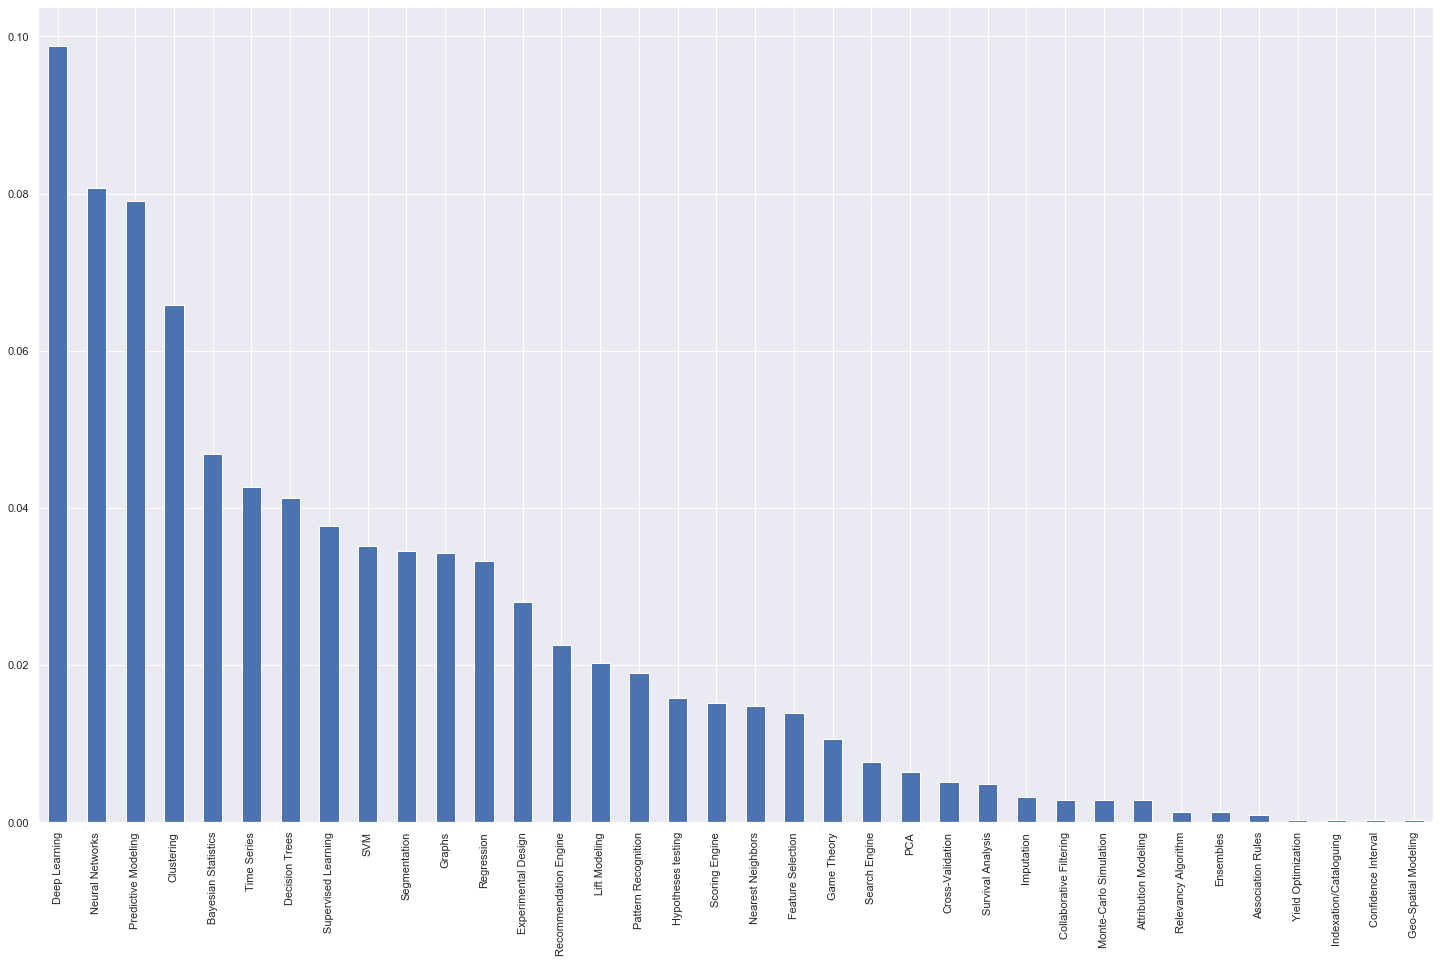

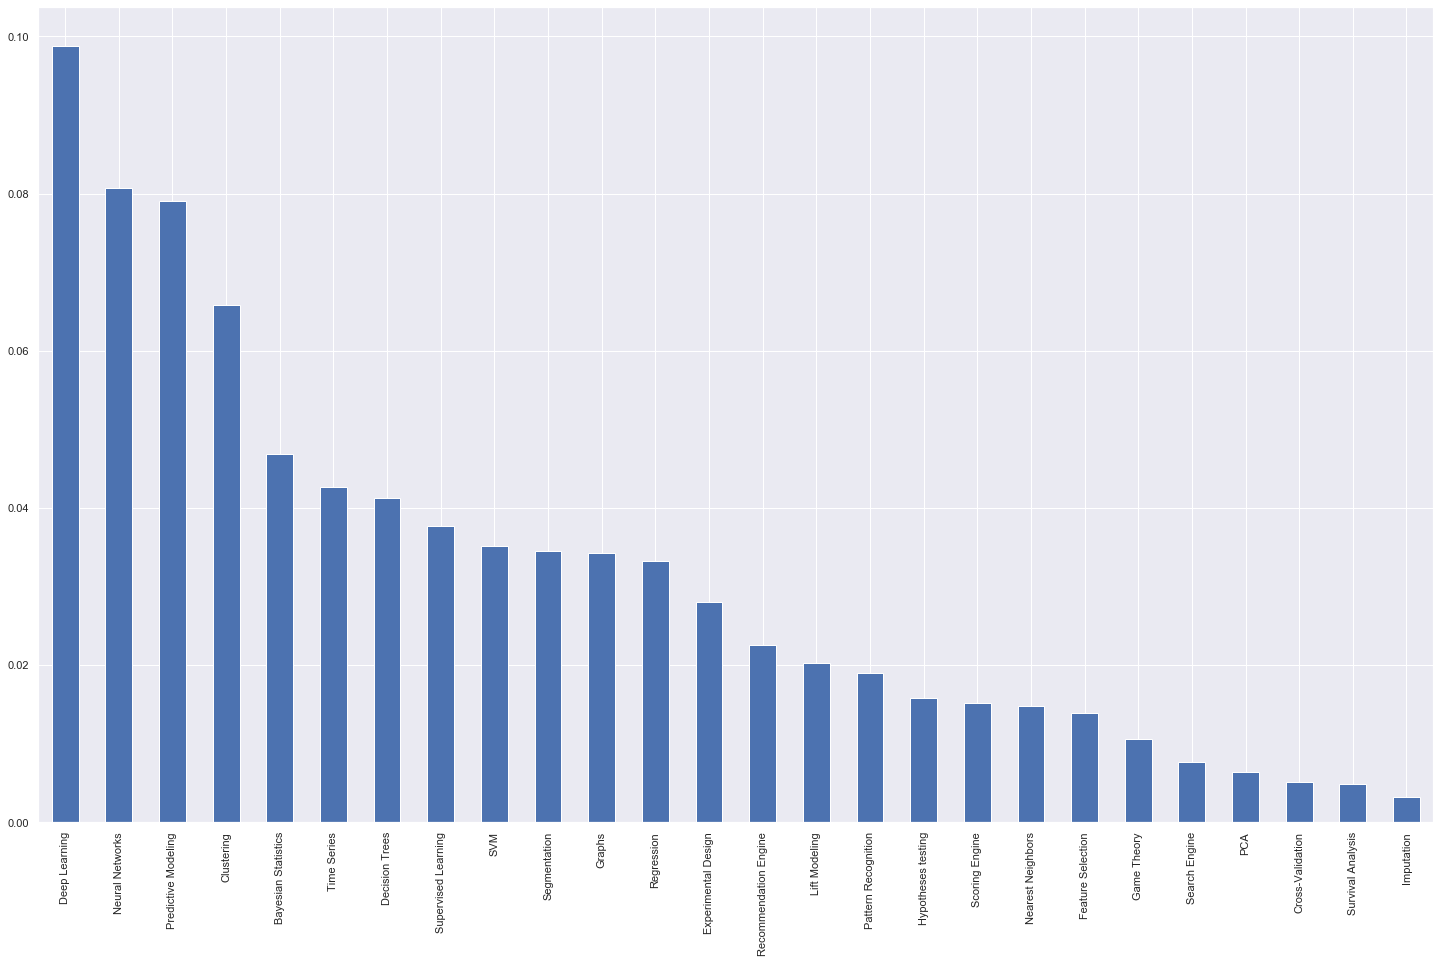

In [130]:
ds_skills=prepare_skills('DS_algo')

ds_res=get_skills(job_ds['Job_Description'], ds_skills)

ds_df = pd.DataFrame(ds_res).apply(pd.to_numeric)

plt.figure(figsize=(25,15))
ds_df.mean().sort_values(ascending=False).plot.bar()
plt.show()

ds_threshold = np.quantile(ds_df.mean(), 0.25)
ds_reduced_df = ds_df[ds_df.columns[ds_df.mean() > ds_threshold]]

plt.figure(figsize=(25,15))
ds_reduced_df.mean().sort_values(ascending=False).plot.bar()
plt.show()

From bar chart we could see that certain DS methodologies are definetly has more demand than others. Top 5 is:
- Deep Learning;
- Neural Networks;
- Predictive Modeling;
- Clustering;
- Bayesian Statistics.

As next step, I will build heatmap and cluster map to see if certain methodologies are logically belongs together and appear in same job offerings simultaneously. 

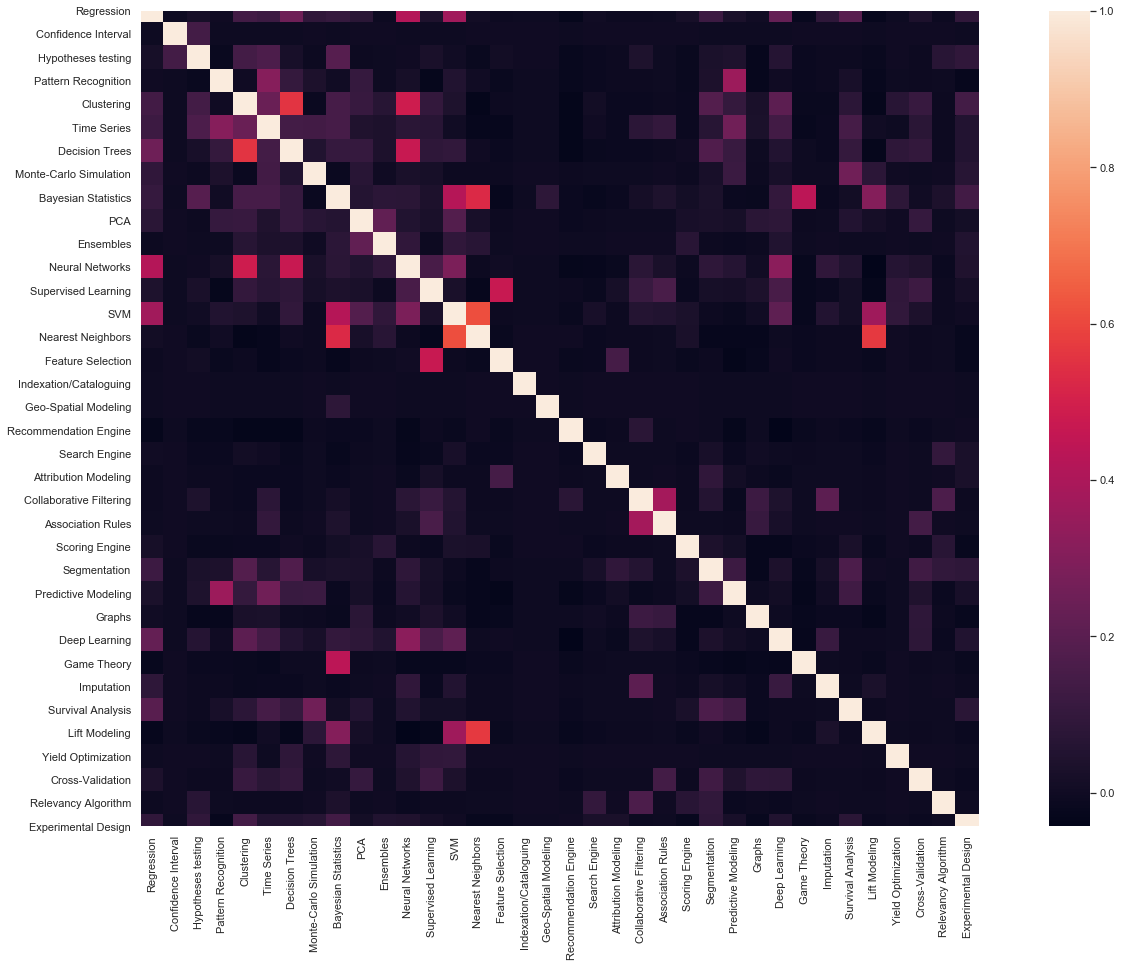

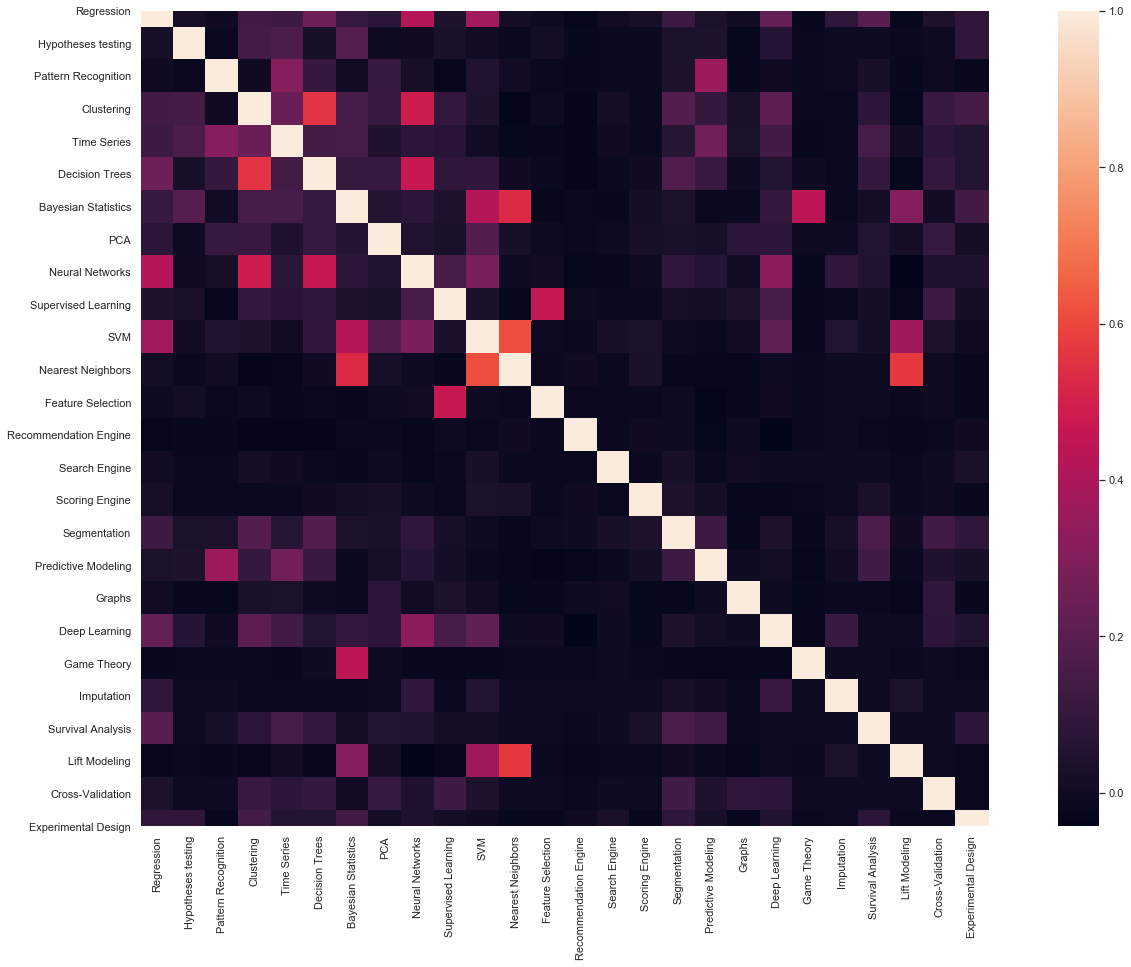

<Figure size 1800x1080 with 0 Axes>

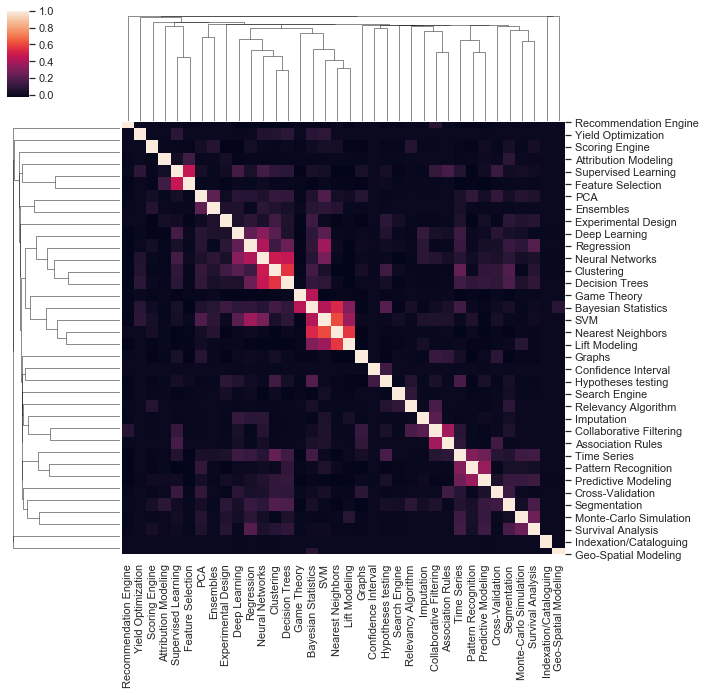

<Figure size 1800x1080 with 0 Axes>

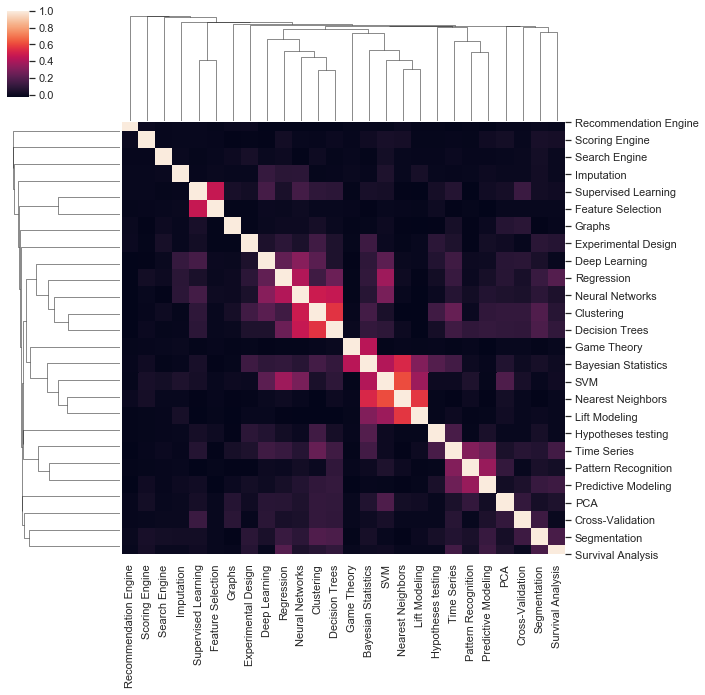

In [128]:
plt.figure(figsize=(25,15))
cor = ds_df.corr() #Calculate the correlation of the above variables
sns.heatmap(cor, square = True) #Plot the correlation as heat map
plt.show()

plt.figure(figsize=(25,15))
cor = ds_reduced_df.corr() #Calculate the correlation of the above variables
sns.heatmap(cor, square = True) #Plot the correlation as heat map
plt.show()

plt.figure(figsize=(25,15))
sns.clustermap(ds_df.corr(), method="single", robust=True)
plt.show()

plt.figure(figsize=(25,15))
sns.clustermap(ds_reduced_df.corr(), method="single", robust=True)
plt.show()

From clustermap it looks like we have certain clusters among DS methodologies. Hence, it make sense to build hierarchical clustering of data.

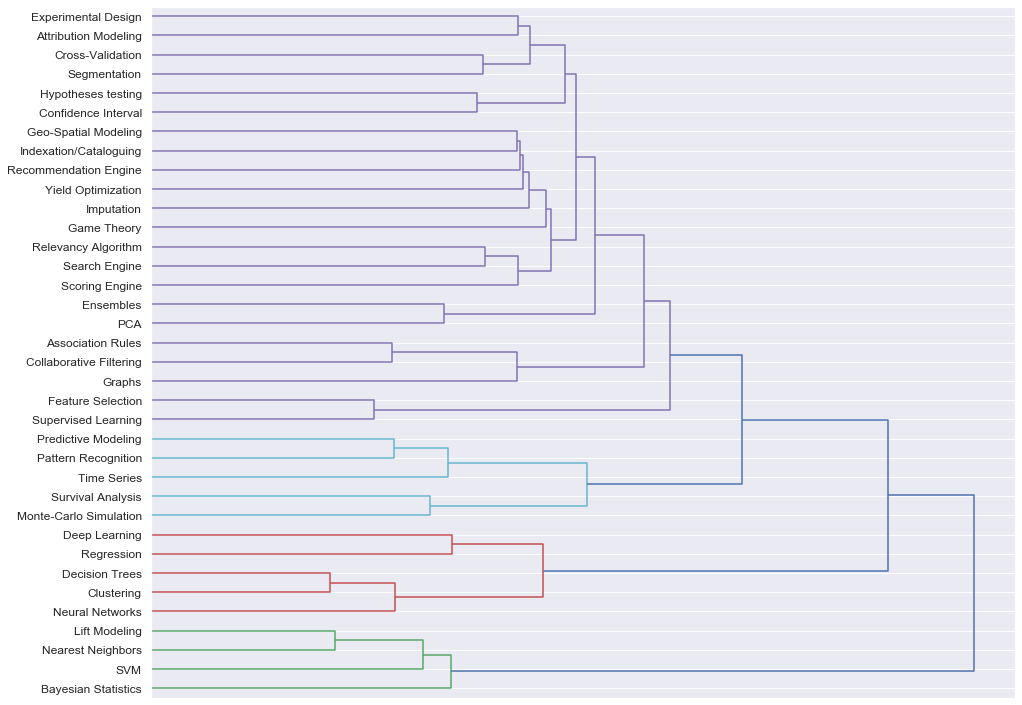

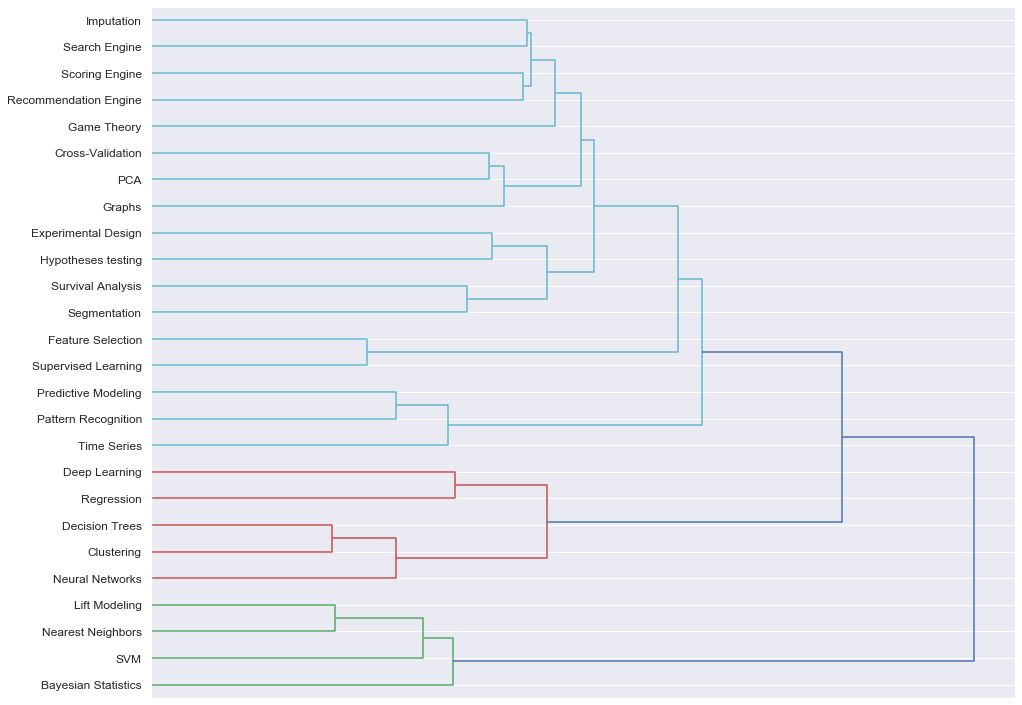

In [129]:
fig = plt.figure(figsize=(30,16))
ax1 = fig.add_axes([0.1,0.1,0.4,0.6])
X=ds_df.corr()
Z=sch.linkage(X, 'ward')
dend = sch.dendrogram(Z, orientation='right', leaf_font_size=12)
labels = X.index[dend['leaves']]
ax1.set_xticks([])
ax1.set_yticklabels(labels)
plt.show()

fig = plt.figure(figsize=(30,16))
ax1 = fig.add_axes([0.1,0.1,0.4,0.6])
X=ds_reduced_df.corr()
Z=sch.linkage(X, 'ward')
dend = sch.dendrogram(Z, orientation='right', leaf_font_size=12)
labels = X.index[dend['leaves']]
ax1.set_xticks([])
ax1.set_yticklabels(labels)
plt.show()

From hierarchical cluster we could derive three main clustrs which are requsted together in different vacancies.
Cluster 1:
- Lift Modeling;
- Nearest Neighbors;
- SVM;
- Bayesian Statistics.

Cluster 2:
- Deep Learning;
- Regression;
- Decission Trees;
- Clustering;
- Neural Networks.

Cluster 3:
- Predictive Modeling;
- Pattern Recognition;
- Time Series;
- Survival Analysis;
- Monte-Carlo Simulation.

All other skills together form rather big cluster, but whithin it we could still see certain smaller clusters like Feature Selection and Supervised Learning or Hypotheses Testing and Confidence Interval and so on. Those smaller clusters still make sense to club together for cirriculum design.


## Part 2 – Data Science program curriculum design

I have prepare wide list of soft skills and respective search terms for those. Using this list I would like to check which ones appears in job vacancies more often and which not. I will check again using simple bar plot for frequency of skills appearing in job postings.

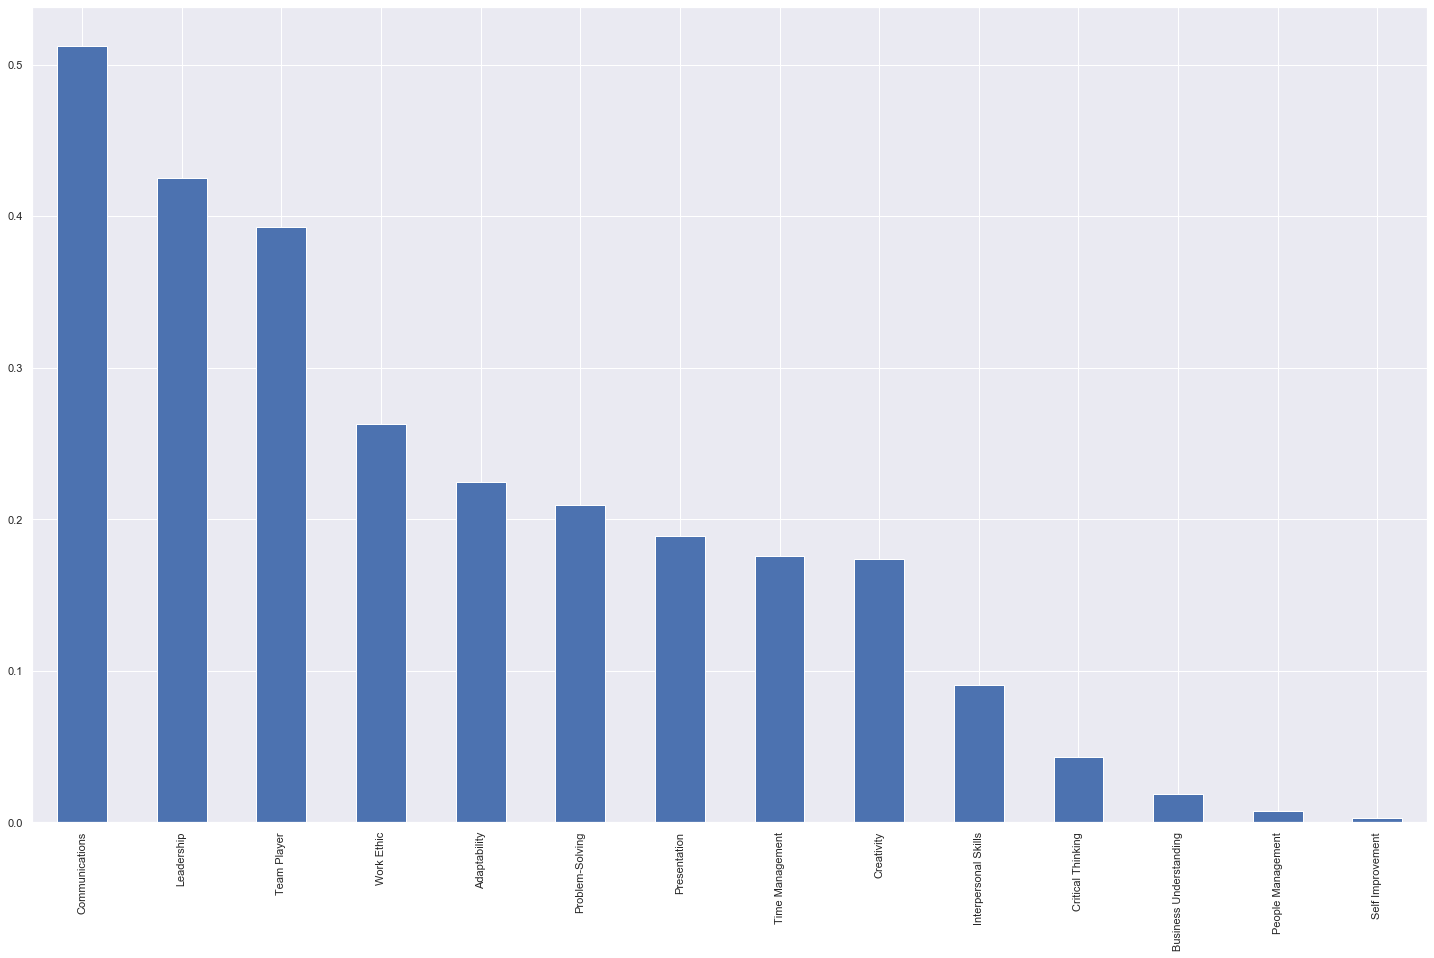

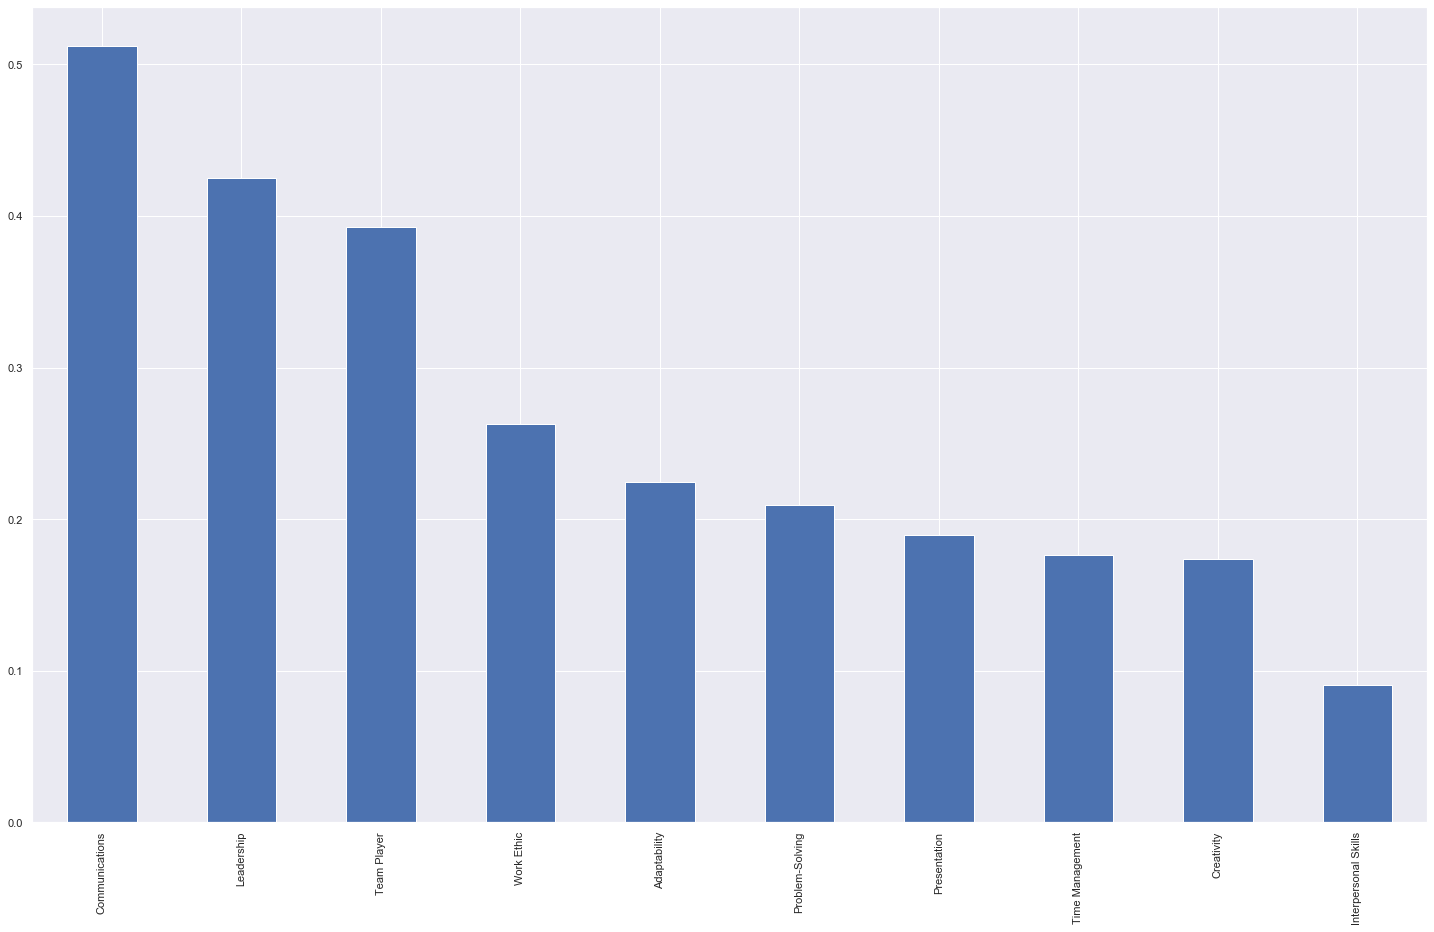

In [131]:
soft_skills=prepare_skills('soft_skills')

soft_res=get_skills(job_ds['Job_Description'], soft_skills)

soft_df = pd.DataFrame(soft_res).apply(pd.to_numeric)

plt.figure(figsize=(25,15))
soft_df.mean().sort_values(ascending=False).plot.bar()
plt.show()

soft_threshold = np.quantile(soft_df.mean(), 0.25)
soft_reduced_df = soft_df[soft_df.columns[soft_df.mean() > soft_threshold]]

plt.figure(figsize=(25,15))
soft_reduced_df.mean().sort_values(ascending=False).plot.bar()
plt.show()

From this bar plot we could see quite strong demand for certain soft skills based on vacancies dataset used for analysis. Top 6 skills are:
- Communications;
- Leadership;
- Team Player;
- Work Ethic;
- Adaptability;
- Problem Solving.

Next, I am building heatmap and clustermap to check whether or not some skills appears together in job offers. 

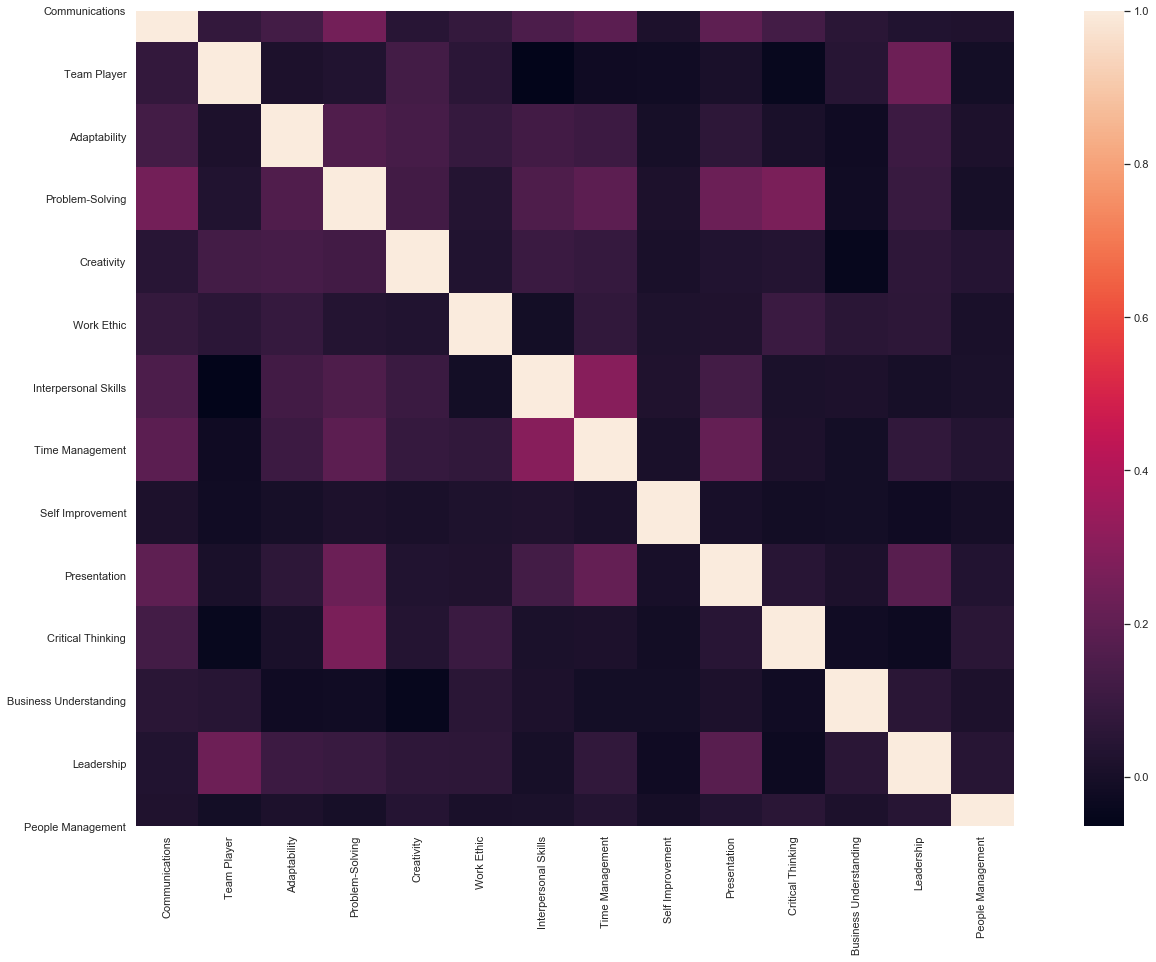

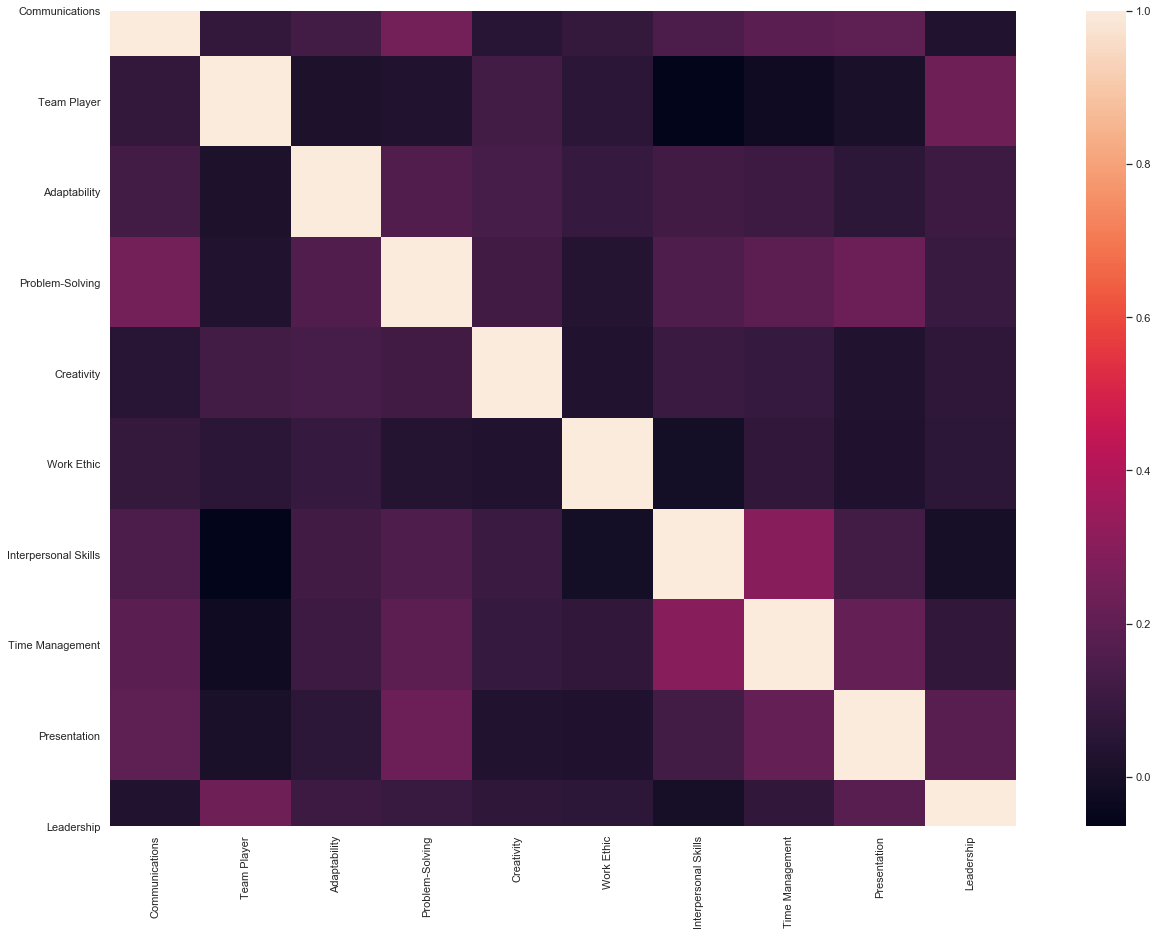

<Figure size 1800x1080 with 0 Axes>

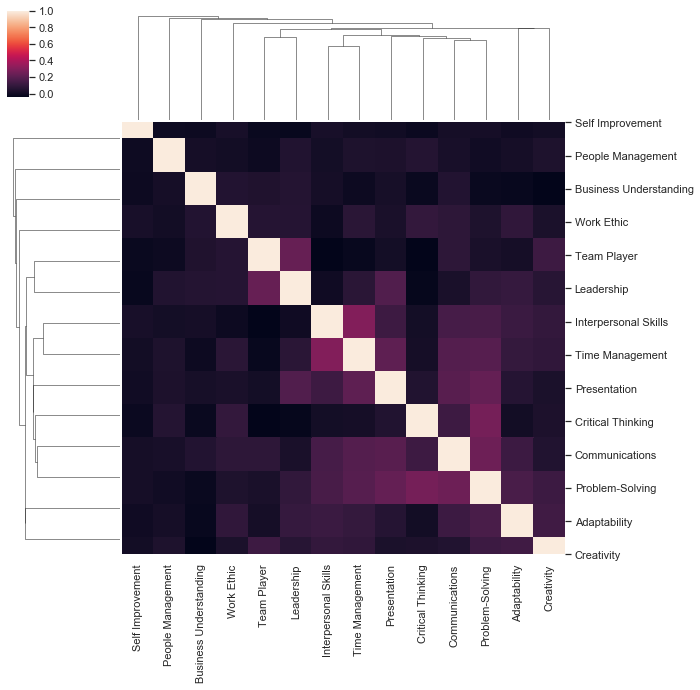

<Figure size 1800x1080 with 0 Axes>

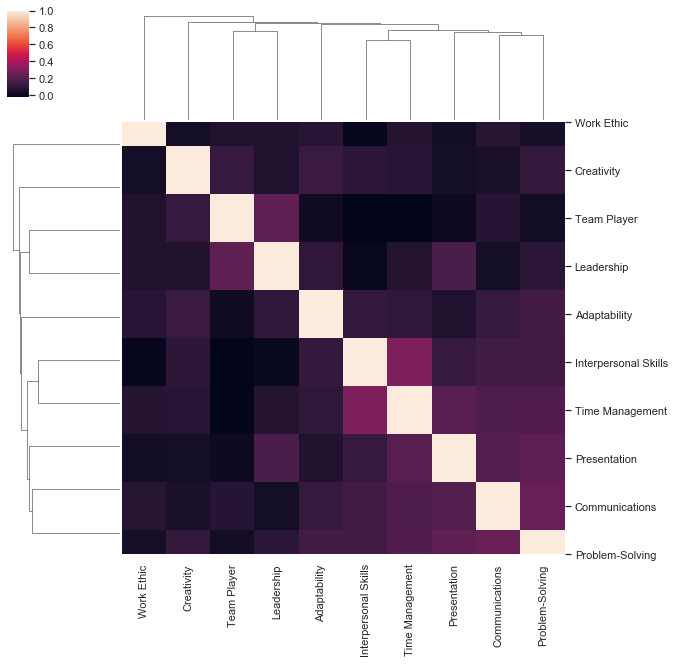

In [138]:
plt.figure(figsize=(25,15))
cor = soft_df.corr() #Calculate the correlation of the above variables
sns.heatmap(cor, square = True) #Plot the correlation as heat map
plt.show()

plt.figure(figsize=(25,15))
cor = soft_reduced_df.corr() #Calculate the correlation of the above variables
sns.heatmap(cor, square = True) #Plot the correlation as heat map
plt.show()

plt.figure(figsize=(25,15))
sns.clustermap(soft_df.corr(), method="single", robust=True)
plt.show()

plt.figure(figsize=(25,15))
sns.clustermap(soft_reduced_df.corr(), method="single", robust=True)
plt.show()

At this point correlation between soft skills not that strong, but still we could see certain posible clusters from clustermap. To explore further, I built hierarchical cluster for soft skill data based on amount of times certain skills appears in job offerings.

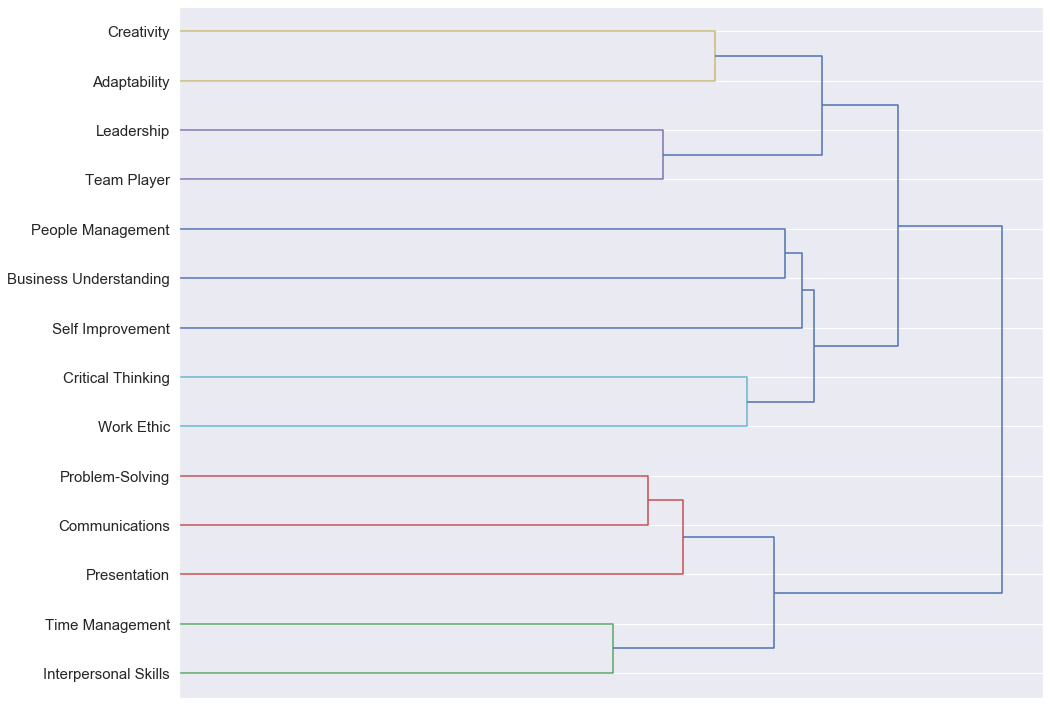

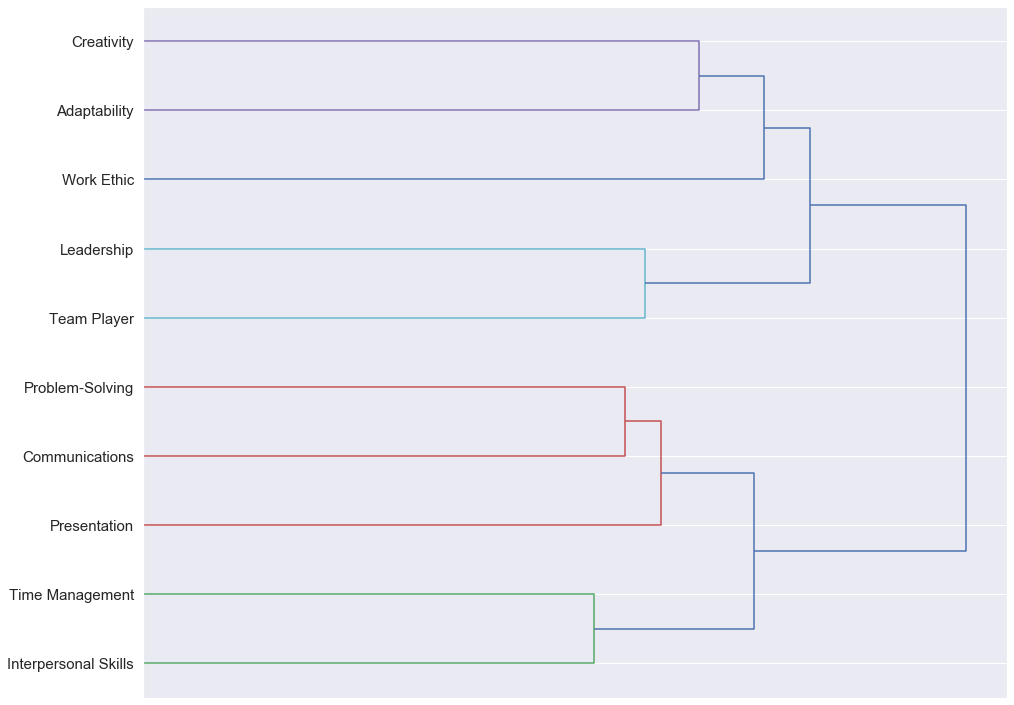

In [139]:
fig = plt.figure(figsize=(30,16))
ax1 = fig.add_axes([0.1,0.1,0.4,0.6])
X=soft_df.corr()
Z=sch.linkage(X, 'ward')
dend = sch.dendrogram(Z, orientation='right', leaf_font_size=15)
labels = X.index[dend['leaves']]
ax1.set_xticks([])
ax1.set_yticklabels(labels)
plt.show()

fig = plt.figure(figsize=(30,16))
ax1 = fig.add_axes([0.1,0.1,0.4,0.6])
X=soft_reduced_df.corr()
Z=sch.linkage(X, 'ward')
dend = sch.dendrogram(Z, orientation='right', leaf_font_size=15)
labels = X.index[dend['leaves']]
ax1.set_xticks([])
ax1.set_yticklabels(labels)
plt.show()

# DRAFTS

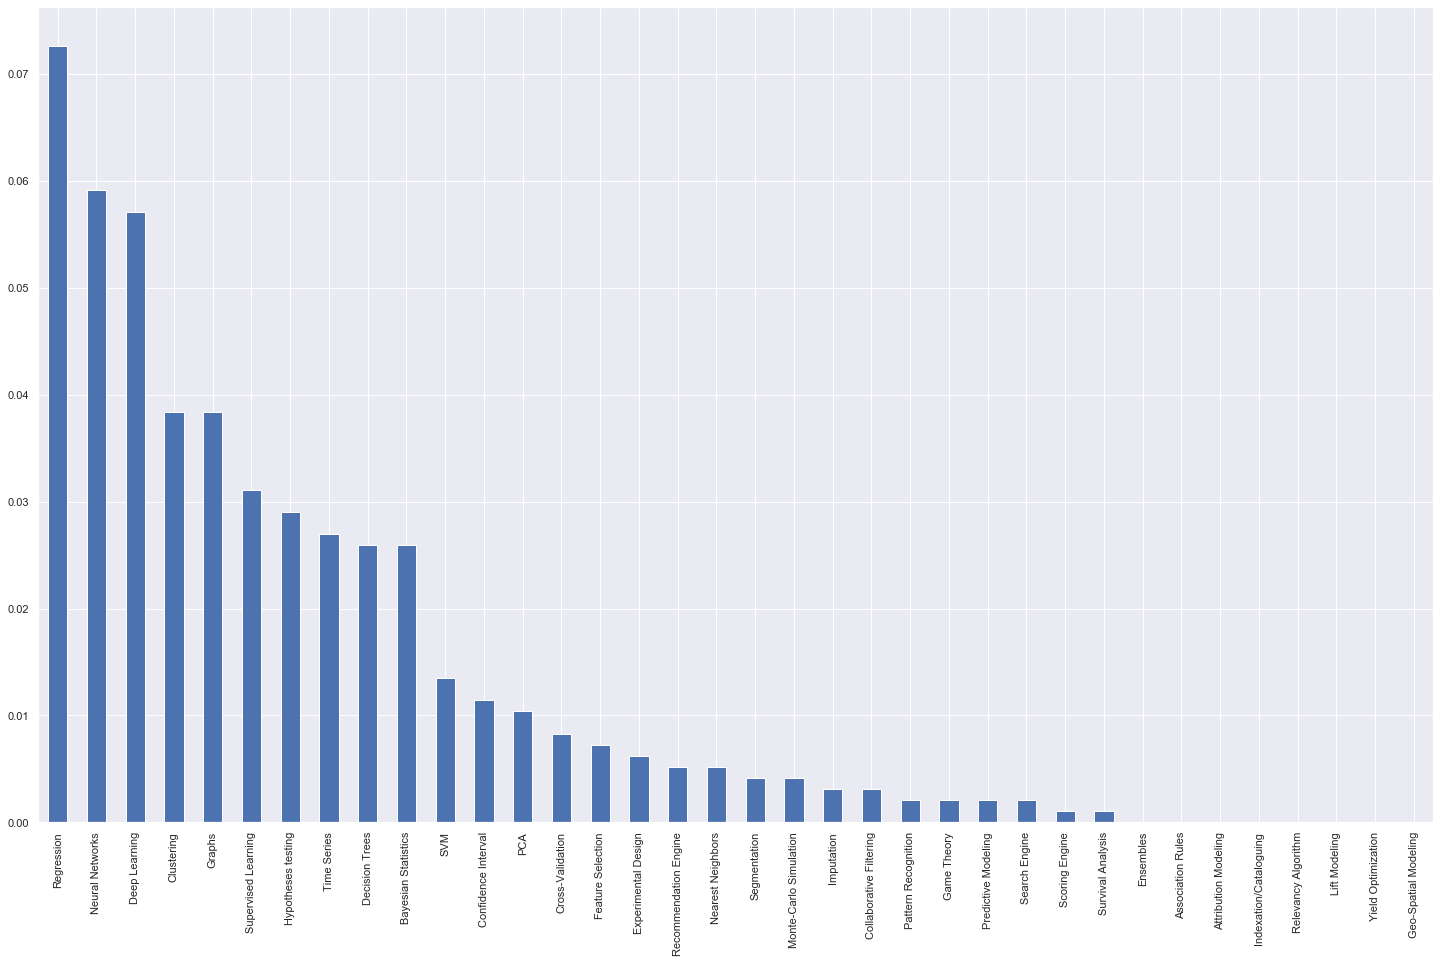

In [177]:
ds_skills=prepare_skills('DS_algo')

ds_courses_res=get_skills(courses_ds['Skills'].astype(dtype=str), ds_skills)

ds_courses_df = pd.DataFrame(ds_courses_res).apply(pd.to_numeric)

plt.figure(figsize=(25,15))
ds_courses_df.mean().sort_values(ascending=False).plot.bar()
plt.show()


<Figure size 1440x720 with 0 Axes>

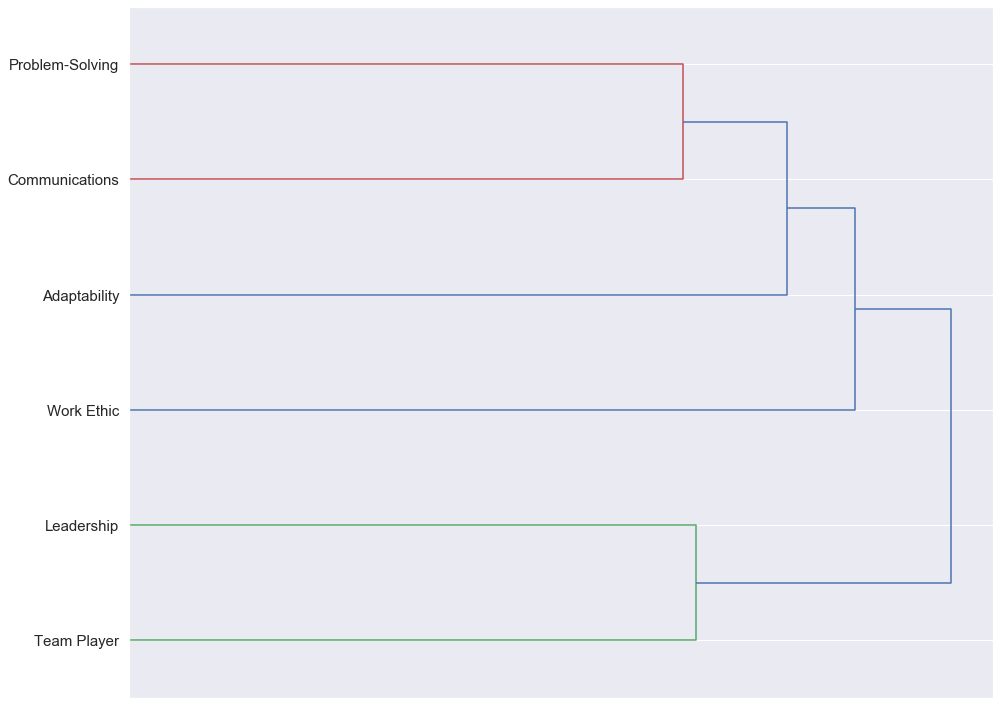

In [108]:
plt.figure(figsize=(20,10))
# sns.pairplot(df.apply(pd.to_numeric)[df.apply(pd.to_numeric) < df.apply(pd.to_numeric).mean()].corr())
plt.show()

mean = np.mean(df.apply(pd.to_numeric).mean())
reduced_df = df.apply(pd.to_numeric)
# .drop(reduced_df.mean() < mean)

reduced_df1 = reduced_df[reduced_df.columns[reduced_df.mean() > mean]]

# reduced_df1.mean().sort_values(ascending=False).plot.bar()

# fig = plt.figure(figsize=(30,16))
# ax1 = fig.add_axes([0.1,0.1,0.4,0.6])
# X=reduced_df1.corr()
# Z=sch.linkage(X, 'ward')
# dend = sch.dendrogram(Z, orientation='right', leaf_font_size=15)
# labels = X.index[dend['leaves']]
# ax1.set_xticks([])
# ax1.set_yticklabels(labels)
# plt.show()

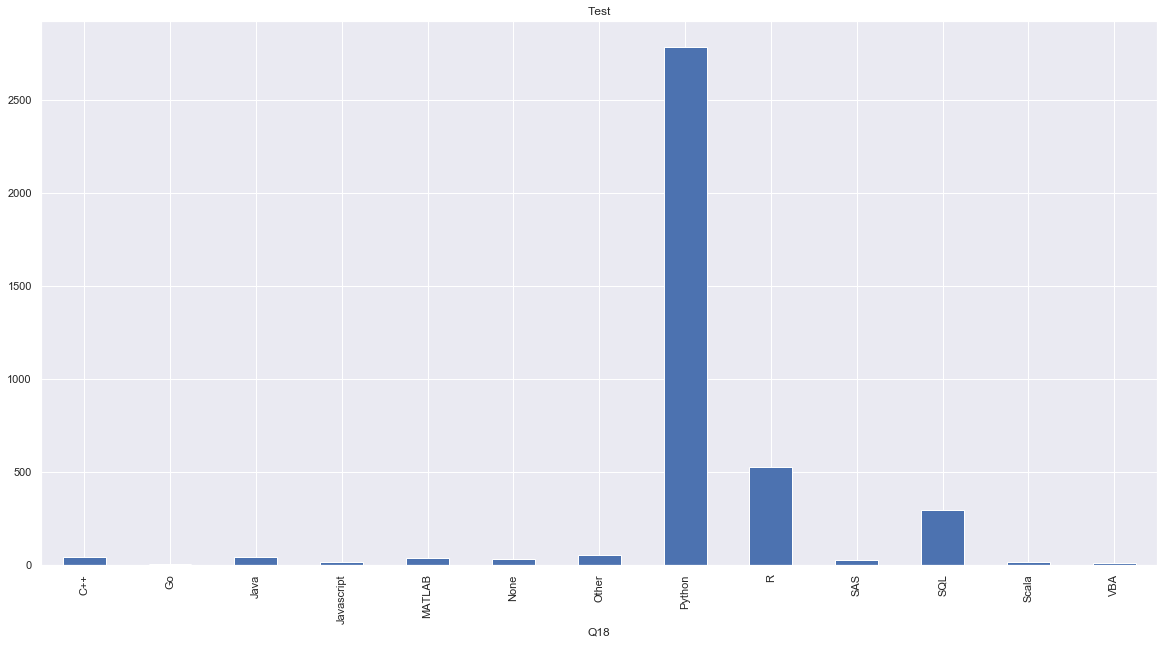

In [8]:
usa_df = kaggle_ds_mult_choice[kaggle_ds_mult_choice.Q3=='United States of America']

plt.figure(figsize=(20,10))
usa_df.groupby(by='Q18').size().plot.bar().set_title('Test')
plt.show()

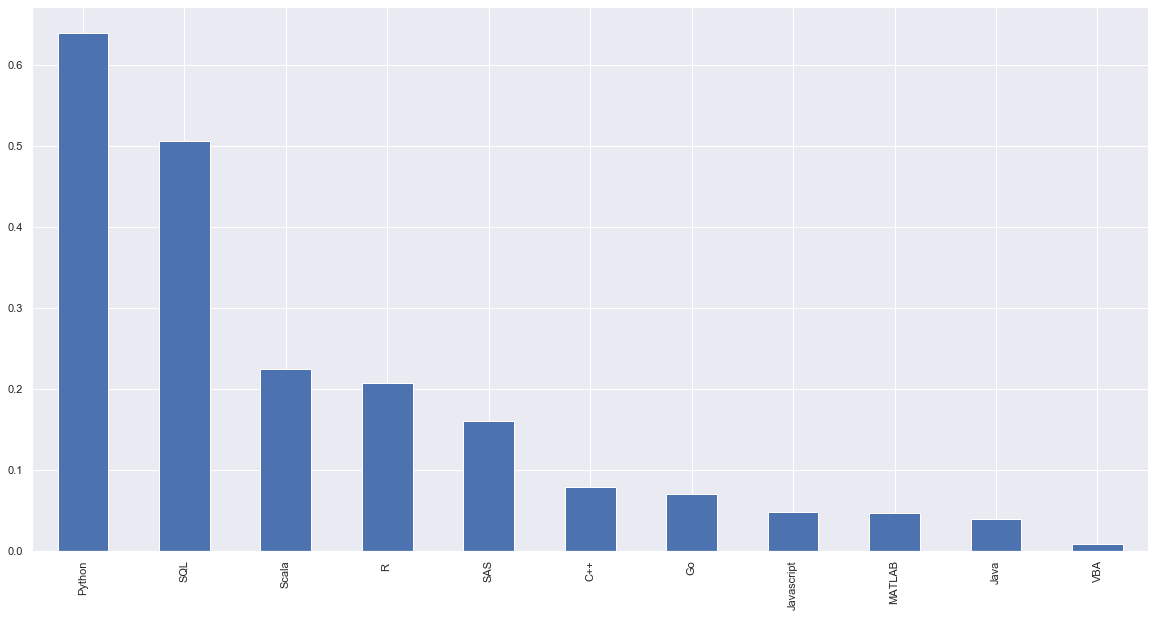

In [10]:
skills=prepare_skills('prog_lang')

res=get_skills(job_ds['Job_Description'], skills)

df = pd.DataFrame(res)

plt.figure(figsize=(20,10))
df.apply(pd.to_numeric).mean().sort_values(ascending=False).plot.bar()
plt.show()